<a href="https://colab.research.google.com/github/MRdvan/Pytorch-Training/blob/master/Pytorch-fundamentals-to-deploy/04_pytorch_custom_datasets_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch Custom Datasets Exercises Template

Welcome to the 04. PyTorch Custom Datasets exercise template.

The best way to practice PyTorch code is to write more PyTorch code.

So read the original notebook and try to complete the exercises by writing code where it's required.

Feel free to reference the original resources whenever you need but should practice writing all of the code yourself.

## Resources

1. These exercises/solutions are based on [notebook 04 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/04_pytorch_custom_datasets/).
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/vsFMF9wqWx0).
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [1]:
# Check for GPU
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [2]:
# Import torch
import torch
from torch import nn

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

1.12.1+cu113


'cpu'

## 1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.

1.   increasing parameter size: increasing the complexity of model will also increase the performans on the training phase

2.   changing learning rate : model might be overshooting the convergence point because of high learning rate

3.   train model longer : if data are complicated to learn, model need to train longer times to find the pattern well

## 2. Recreate the data loading functions we built in [sections 1, 2, 3 and 4 of notebook 04](https://www.learnpytorch.io/04_pytorch_custom_datasets/). You should have train and test `DataLoader`'s ready to use.

In [4]:
# 1. Get data
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [5]:
# 2. Become one with the data
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning file counts of its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [6]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir,test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

Random image path: data/pizza_steak_sushi/train/steak/2561199.jpg
Image class: steak
Image height: 512
Image width: 512


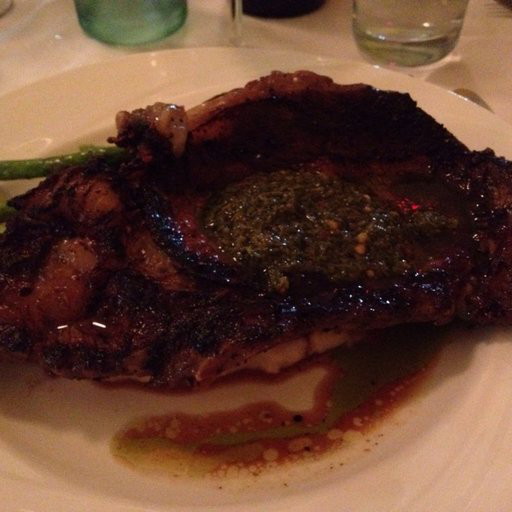

In [7]:
# Visualize an image
import random
from PIL import Image

random.seed(42)
image_path_list = list(image_path.glob("*/*/*.jpg"))

random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

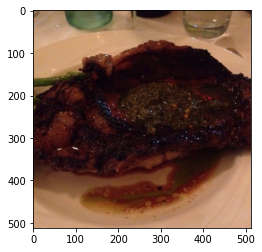

In [9]:
# Do the image visualization with matplotlib
import numpy as np
import matplotlib.pyplot as plt

img_as_arrray = np.array(img)

plt.imshow(img_as_arrray)

We've got some images in our folders.

Now we need to make them compatible with PyTorch by:
1. Transform the data into tensors.
2. Turn the tensor data into a `torch.utils.data.Dataset` and later a `torch.utils.data.DataLoader`.

In [10]:
# 3.1 Transforming data with torchvision.transforms
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [12]:
# Write transform for turning images into tensors
transform = transforms.Compose([
    transforms.Resize(size=(128,128)),
    transforms.ToTensor()
])

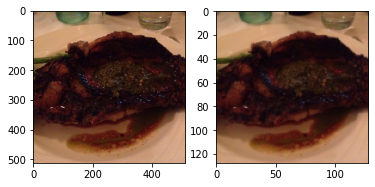

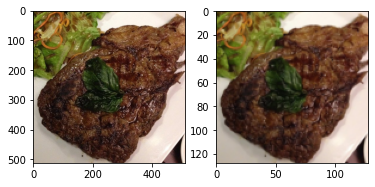

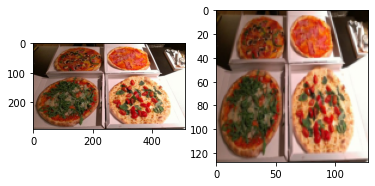

In [13]:
# Write a function to plot transformed images
def plot_transformed_images(image_paths,transform,n=3,seed=42):
  random.seed(seed)
  random_image_path = random.sample(image_paths,k=n)
  for image_path in random_image_path:
    with Image.open(image_path) as f:
      fig,(ax1,ax2) = plt.subplots(1,2)
      ax1.imshow(f)
      ax2.imshow(transform(f).permute(1,2,0))

plot_transformed_images(image_path_list, 
                        transform=transform, 
                        n=3)

### Load image data using `ImageFolder`

In [14]:
# Use ImageFolder to create dataset(s)
train_data = datasets.ImageFolder(train_dir,transform = transform,target_transform = None)

test_data = datasets.ImageFolder(root=test_dir, 
                                 transform=transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )


In [15]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [16]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [17]:
# Check the lengths of each dataset
len(train_data), len(test_data)

(225, 75)

In [39]:
# Turn train and test Datasets into DataLoaders
train_loader = DataLoader(train_data,batch_size = 25,shuffle = True,num_workers=os.cpu_count())
test_loader = DataLoader(test_data,batch_size = 25,shuffle = False,num_workers=os.cpu_count())

In [40]:
# How many batches of images are in our data loaders?
len(train_loader),len(test_loader)

(9, 3)

In [46]:
img,label = next(iter(train_loader))
img.shape,label.shape

(torch.Size([25, 3, 128, 128]), torch.Size([25]))

## 3. Recreate `model_0` we built in section 7 of notebook 04.

In [47]:
class TinyVGG(nn.Module):

    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, 
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) 
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*32*32,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=10240, out_features=3, bias=True)
  )
)

## 4. Create training and testing functions for `model_0`.

In [48]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [49]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [50]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
  
  # Create results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through the training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    # Train step
    train_loss, train_acc = train_step(model=model, 
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    # Test step
    test_loss, test_acc = test_step(model=model, 
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)
    
    # Print out what's happening
    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
    )

    # Update the results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return the results dictionary
  return results

## 5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?
* Use `torch.optim.Adam()` with a learning rate of 0.001 as the optimizer. 

In [51]:
# Train for 5 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 5

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Train model_0 
model_0_results = train(model=model_0, 
                        train_dataloader=train_loader,
                        test_dataloader=test_loader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1393 | train_acc: 0.3422 | test_loss: 1.1653 | test_acc: 0.3333
Epoch: 2 | train_loss: 1.1335 | train_acc: 0.2800 | test_loss: 1.0856 | test_acc: 0.4133
Epoch: 3 | train_loss: 1.1022 | train_acc: 0.3244 | test_loss: 1.1096 | test_acc: 0.3333
Epoch: 4 | train_loss: 1.0982 | train_acc: 0.3156 | test_loss: 1.1077 | test_acc: 0.2933
Epoch: 5 | train_loss: 1.0731 | train_acc: 0.4311 | test_loss: 1.0805 | test_acc: 0.4000


In [52]:
# Train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 20

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Train model_0 
model_0_results = train(model=model_0, 
                        train_dataloader=train_loader,
                        test_dataloader=test_loader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0321 | train_acc: 0.4800 | test_loss: 1.0559 | test_acc: 0.3867
Epoch: 2 | train_loss: 0.9563 | train_acc: 0.5467 | test_loss: 1.0243 | test_acc: 0.3867
Epoch: 3 | train_loss: 0.8909 | train_acc: 0.5644 | test_loss: 1.0769 | test_acc: 0.4000
Epoch: 4 | train_loss: 0.8405 | train_acc: 0.6444 | test_loss: 1.0287 | test_acc: 0.4133
Epoch: 5 | train_loss: 0.8163 | train_acc: 0.6533 | test_loss: 1.0323 | test_acc: 0.4400
Epoch: 6 | train_loss: 0.7818 | train_acc: 0.6400 | test_loss: 1.0274 | test_acc: 0.4533
Epoch: 7 | train_loss: 0.7621 | train_acc: 0.6756 | test_loss: 1.0293 | test_acc: 0.3733
Epoch: 8 | train_loss: 0.7462 | train_acc: 0.6933 | test_loss: 1.0142 | test_acc: 0.4800
Epoch: 9 | train_loss: 0.7305 | train_acc: 0.6667 | test_loss: 1.0649 | test_acc: 0.4667
Epoch: 10 | train_loss: 0.7025 | train_acc: 0.6978 | test_loss: 1.0331 | test_acc: 0.4667
Epoch: 11 | train_loss: 0.6704 | train_acc: 0.6933 | test_loss: 1.0946 | test_acc: 0.4133
Epoch: 12 | train_l

In [53]:
# Train for 50 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 50

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Train model_0 
model_0_results = train(model=model_0, 
                        train_dataloader=train_loader,
                        test_dataloader=test_loader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2900 | train_acc: 0.9067 | test_loss: 1.6554 | test_acc: 0.4800
Epoch: 2 | train_loss: 0.2359 | train_acc: 0.9289 | test_loss: 1.7202 | test_acc: 0.3867
Epoch: 3 | train_loss: 0.2108 | train_acc: 0.9333 | test_loss: 1.8004 | test_acc: 0.4667
Epoch: 4 | train_loss: 0.1608 | train_acc: 0.9600 | test_loss: 2.0089 | test_acc: 0.4933
Epoch: 5 | train_loss: 0.1403 | train_acc: 0.9733 | test_loss: 1.8904 | test_acc: 0.4667
Epoch: 6 | train_loss: 0.0851 | train_acc: 0.9911 | test_loss: 2.1091 | test_acc: 0.4533
Epoch: 7 | train_loss: 0.0691 | train_acc: 0.9867 | test_loss: 2.3530 | test_acc: 0.4667
Epoch: 8 | train_loss: 0.0463 | train_acc: 0.9956 | test_loss: 2.5517 | test_acc: 0.4933
Epoch: 9 | train_loss: 0.0565 | train_acc: 0.9778 | test_loss: 2.5582 | test_acc: 0.4533
Epoch: 10 | train_loss: 0.0371 | train_acc: 0.9956 | test_loss: 2.7109 | test_acc: 0.4533
Epoch: 11 | train_loss: 0.0239 | train_acc: 1.0000 | test_loss: 2.8769 | test_acc: 0.4533
Epoch: 12 | train_l

It looks like our model is starting to overfit towards the end (performing far better on the training data than on the testing data).

In order to fix this, we'd have to introduce ways of preventing overfitting.

## 6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

In [54]:
# Double the number of hidden units and train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=20, 
                  output_shape=len(train_data.classes)).to(device)

NUM_EPOCHS = 20

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Train model_0 
model_0_results = train(model=model_0, 
                        train_dataloader=train_loader,
                        test_dataloader=test_loader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1145 | train_acc: 0.3244 | test_loss: 1.0907 | test_acc: 0.3333
Epoch: 2 | train_loss: 1.0994 | train_acc: 0.3422 | test_loss: 1.0954 | test_acc: 0.3600
Epoch: 3 | train_loss: 1.0912 | train_acc: 0.3778 | test_loss: 1.0781 | test_acc: 0.4000
Epoch: 4 | train_loss: 1.0173 | train_acc: 0.4978 | test_loss: 0.9913 | test_acc: 0.4667
Epoch: 5 | train_loss: 0.9155 | train_acc: 0.5467 | test_loss: 1.1319 | test_acc: 0.4267
Epoch: 6 | train_loss: 0.8842 | train_acc: 0.5556 | test_loss: 1.0993 | test_acc: 0.4133
Epoch: 7 | train_loss: 0.8722 | train_acc: 0.6044 | test_loss: 1.0223 | test_acc: 0.4533
Epoch: 8 | train_loss: 0.7332 | train_acc: 0.7200 | test_loss: 1.0891 | test_acc: 0.4533
Epoch: 9 | train_loss: 0.6342 | train_acc: 0.7422 | test_loss: 1.1644 | test_acc: 0.4800
Epoch: 10 | train_loss: 0.5395 | train_acc: 0.8178 | test_loss: 1.2009 | test_acc: 0.4533
Epoch: 11 | train_loss: 0.4108 | train_acc: 0.8489 | test_loss: 1.4874 | test_acc: 0.4667
Epoch: 12 | train_l

It looks like the model is still overfitting, even when changing the number of hidden units.

To fix this, we'd have to look at ways to prevent overfitting with our model.

## 7. Double the data you're using with your model from step 6 and train it for 20 epochs, what happens to the results?
* **Note:** You can use the [custom data creation notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) to scale up your Food101 dataset.
* You can also find the [already formatted double data (20% instead of 10% subset) dataset on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip), you will need to write download code like in exercise 2 to get it into this notebook.

In [55]:
# Download 20% data for Pizza/Steak/Sushi from GitHub
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("Downloading pizza, steak, sushi 20% data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi 20% data...") 
    zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi_20_percent directory, creating one...
Unzipping pizza, steak, sushi 20% data...


In [56]:
# See how many images we have
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi_20_percent'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/train'.
There are 0 directories and 146 images in 'data/pizza_steak_sushi_20_percent/train/steak'.
There are 0 directories and 154 images in 'data/pizza_steak_sushi_20_percent/train/pizza'.
There are 0 directories and 150 images in 'data/pizza_steak_sushi_20_percent/train/sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi_20_percent/test'.
There are 0 directories and 58 images in 'data/pizza_steak_sushi_20_percent/test/steak'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/pizza'.
There are 0 directories and 46 images in 'data/pizza_steak_sushi_20_percent/test/sushi'.


Excellent, we now have double the training and testing images... 

In [57]:
# Create the train and test paths
train_data_20_percent_path = image_path / "train"
test_data_20_percent_path = image_path / "test"

train_data_20_percent_path, test_data_20_percent_path

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

In [64]:
# Turn the 20 percent datapaths into Datasets and DataLoaders
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

simple_transform = transforms.Compose([
  transforms.Resize((128, 128)),    
  transforms.RandomHorizontalFlip(p=0.5),  
  transforms.TrivialAugmentWide(num_magnitude_bins=31),                      
  transforms.ToTensor()
])

# Create datasets
# Use ImageFolder to create dataset(s)
train_data_simple = datasets.ImageFolder(train_data_20_percent_path,transform = simple_transform,target_transform = None)

test_data_simple = datasets.ImageFolder(root=test_data_20_percent_path, 
                                 transform=transform)

print(f"Train data:\n{train_data_simple}\nTest data:\n{test_data_simple}")

# Create dataloaders

# Turn train and test Datasets into DataLoaders
train_loader_simple = DataLoader(train_data_simple,batch_size = 25,shuffle = True,num_workers=os.cpu_count())
test_loader_simple = DataLoader(test_data_simple,batch_size = 25,shuffle = False,num_workers=os.cpu_count())


Train data:
Dataset ImageFolder
    Number of datapoints: 450
    Root location: data/pizza_steak_sushi_20_percent/train
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 150
    Root location: data/pizza_steak_sushi_20_percent/test
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )


In [65]:
# Train a model with increased amount of data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=20, 
                  output_shape=len(train_data_simple.classes)).to(device)

NUM_EPOCHS = 20

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001,weight_decay=0.0001)

# Train model_0 
model_0_results = train(model=model_0, 
                        train_dataloader=train_loader_simple,
                        test_dataloader=test_loader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1015 | train_acc: 0.3556 | test_loss: 1.0603 | test_acc: 0.4933
Epoch: 2 | train_loss: 1.0361 | train_acc: 0.4711 | test_loss: 0.9586 | test_acc: 0.4733
Epoch: 3 | train_loss: 0.9836 | train_acc: 0.5044 | test_loss: 0.8992 | test_acc: 0.5533
Epoch: 4 | train_loss: 0.9733 | train_acc: 0.4978 | test_loss: 0.8783 | test_acc: 0.5933
Epoch: 5 | train_loss: 0.9163 | train_acc: 0.5467 | test_loss: 0.8901 | test_acc: 0.5600
Epoch: 6 | train_loss: 0.8986 | train_acc: 0.5756 | test_loss: 0.8477 | test_acc: 0.6267
Epoch: 7 | train_loss: 0.9138 | train_acc: 0.5422 | test_loss: 0.8653 | test_acc: 0.5867
Epoch: 8 | train_loss: 0.8878 | train_acc: 0.5644 | test_loss: 0.8690 | test_acc: 0.5933
Epoch: 9 | train_loss: 0.9042 | train_acc: 0.5778 | test_loss: 0.8637 | test_acc: 0.6133
Epoch: 10 | train_loss: 0.9046 | train_acc: 0.5667 | test_loss: 0.8972 | test_acc: 0.5533
Epoch: 11 | train_loss: 0.8872 | train_acc: 0.5978 | test_loss: 0.8921 | test_acc: 0.5467
Epoch: 12 | train_l

## 8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) with your trained model from exercise 7 and share your prediction. 
* Does the model you trained in exercise 7 get it right? 
* If not, what do you think you could do to improve it?

In [66]:
# data augmentation method added to transformation to solve overfitting issue
# also weight decay added in the optimizer function to do regularization 

#Now models training and testing accuracy very close to eachother if we keep training the model we can achive a good result ....